In [1]:
import datetime
import redis

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from contextlib import contextmanager
import time

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
BENCHMARK = []

@contextmanager
def benchthis(label):
    global BENCHMARK
    start = time.time()
    try:
        yield
    finally:
        end = time.time()
        BENCHMARK.append(end-start)
        #print ('{}: {:.4f}s'.format(label, end-start))

@contextmanager
def just_time_it(label):
    start = time.time()
    try:
        yield
    finally:
        end = time.time()
        print ('{}: {:.4f}s'.format(label, end-start))

In [4]:
import tsdb
pool = redis.ConnectionPool(host='localhost', port=6379, db=0)
conn = redis.Redis(connection_pool=pool)
conn.flushdb()

True

In [5]:
def write_and_read(conn, ts, series, repeat=10):
    start = datetime.datetime.fromtimestamp(series.index[0].timestamp())-series.index[0].utcoffset()
    end = datetime.datetime.fromtimestamp(series.index[-1].timestamp())-series.index[-1].utcoffset()
    #print (start, end)
    with benchthis('write data: {}'.format(len(series))):
        for i in range(repeat):
            tsdb.write_data(conn, ts.pk, series)
    with benchthis('read data: {}'.format(len(series))):
        for i in range(repeat):
            read_series = tsdb.read_data(conn, ts.pk, start, end)
    #print (len(series), len(read_series), end=': ')
    #print (all(series == read_series))

def make_series(N=8760):
    index = pd.date_range(
        start='1/1/2015',
        periods=N,
        freq='1H',
        tz='CET'
    )
    return pd.Series(np.arange(1, N+1), index)

In [6]:
ts1 = tsdb.ts_struct(-1, 'benchmark', '1H', 'CET')
ts_id = tsdb.create_new_ts(conn, ts1)
ts = tsdb.read_ts(conn, ts_id)
ts

repeat = 15
bench_list = list(range(4380, 8760*20, 4380))
BENCHMARK = []
for size in bench_list:
    #print (size, end=': ')
    s = make_series(size)
    write_and_read(conn, ts, s, repeat=repeat)

78 39


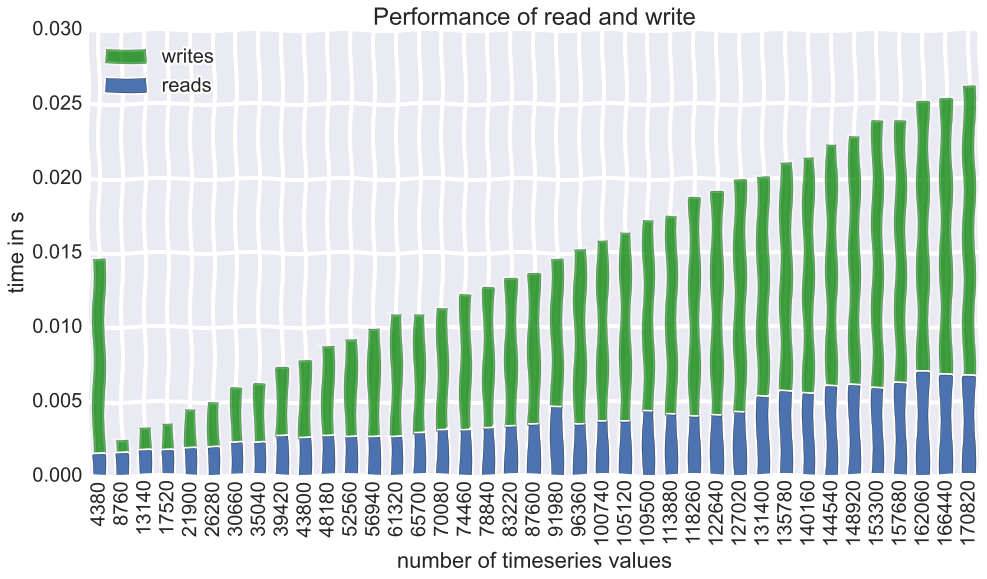

In [7]:
print (len(BENCHMARK), len(bench_list))
with plt.xkcd():
    s_read = pd.Series(np.array(BENCHMARK[1::2])/repeat, bench_list)
    s_write = pd.Series(np.array(BENCHMARK[::2])/repeat, bench_list)
    sns.set(font_scale=2)
    sns.plt.figure(figsize=(16, 8))
    sns.plt.title('Performance of read_d and write')
    s_write.plot(kind='bar', label='writes', alpha=0.5, color='green')
    s_read.plot(kind='bar', label='reads')#, alpha=0.5)
    sns.plt.ylabel('time in s')
    sns.plt.xlabel('number of timeseries values')
    sns.plt.legend(loc='best')